# This files provides all the code to reproduce the Figures used in Appendix B for the descriptive statitics.

In [1]:
%load_ext autoreload
%autoreload 2

import click
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses

import pandas as pd
import numpy as np
import random
import os
import scipy.stats as ss
from numpy import *
import math
import random
import gzip
import pickle as pkl
import collections


from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import ndcg_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns
import matplotlib.pyplot as plt
import utils


/home/mheuillet/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


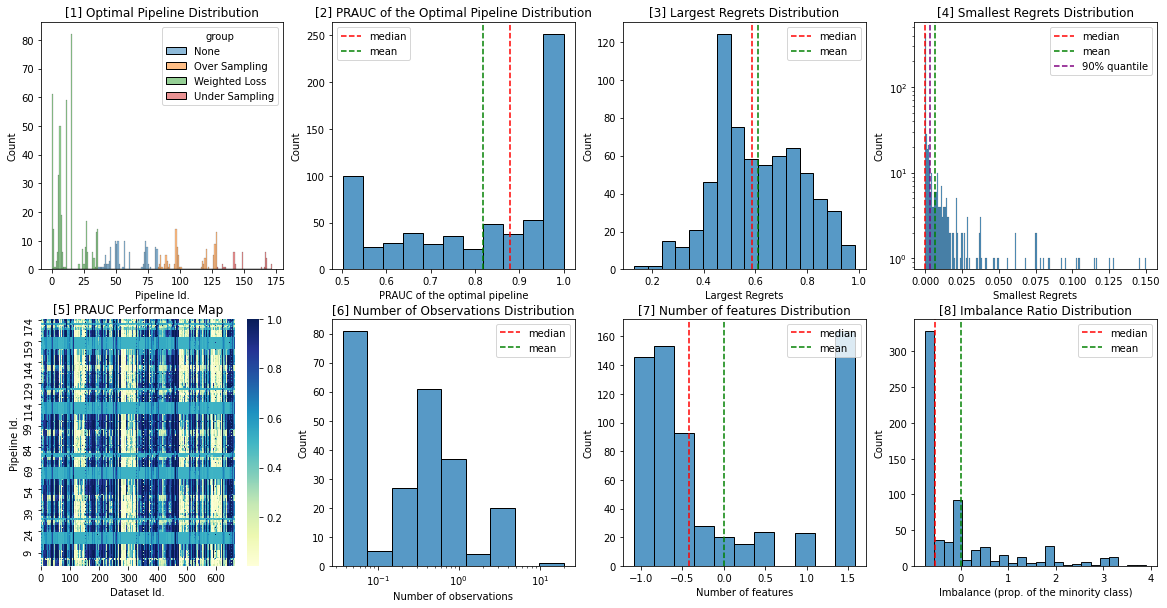

In [32]:
X_GB, y_GB = utils.load_data_175_avg('a', 666)

X_GB.columns = cols =   [  'size', 'nb_class', 'nb_timeseries', 'log_nb_timeseries', 'timesteps', 
            'log_timesteps', 'entropy', 'ratio', 'imbalance',  'avg_skewness', 'std_skewness', 'min_skewness', 'max_skewness',
            'avg_kurto', 'std_kurto', 'min_kurto', 'max_kurto',
            'avg_std', 'std_std', 'min_std', 'max_std', 
            'avg_mean', 'std_mean', 'min_mean', 'max_mean', 
            'avg_cv', 'std_cv', 'min_cv', 'max_cv' ]

X_GB['y_opt'] = [ max(y_GB.loc[idx]) for idx in y_GB.index  ]
X_GB['k_opt']= [ np.argmax(y_GB.loc[idx]) for idx in y_GB.index  ]

petit_regret = [] # we compute the smallest and largest regrets
grand_regret = []

for idx in y_GB.index:
    opt = y_GB.loc[idx, np.argsort(y_GB.loc[idx].T.values)[-1] ]
    mini = y_GB.loc[idx, np.argsort(y_GB.loc[idx].T.values)[-2] ]
    maxi = y_GB.loc[idx, np.argsort(y_GB.loc[idx].T.values)[0] ]
    
    petit_regret.append(opt-mini)
    grand_regret.append(opt-maxi)

X_GB['petits_regrets'] = petit_regret
X_GB['grands_regrets']= grand_regret

WG = [ 'WG_SVM1a', 'WG_SVM1b', 'WG_SVM1c', 'WG_SVM1d', 
  'WG_SVM2a', 'WG_SVM2b', 'WG_SVM2c', 'WG_SVM2d', 'WG_SVM2e', 'WG_SVM2f','WG_SVM2g',
  'WG_KNN1', 'WG_KNN2', 'WG_KNN3', 'WG_KNN4',
  'WG_RKNN1', 'WG_RKNN2', 'WG_RKNN3', 'WG_RKNN4',
  'WG_RKNN5', 'WG_RKNN6', 'WG_RKNN7', 'WG_RKNN8', 'WG_RKNN9',
  'WG_RF1', 'WG_RF2', 'WG_RF3', 'WG_RF4', 'WG_RF5',
  'WG_SGDCL11', 'WG_SGDCL12', 'WG_SGDCL13', 'WG_SGDCL14',
  'WG_SGDCL15', 'WG_MLP1_1', 'WG_MLP1_10', 'WG_MLP1_100' ]
                     
NO = [  'NO_GBa', 'NO_GBb', 'NO_GBc', 'NO_GBd', 'NO_GBe',
  'NO_GBf', 'NO_GBg', 'NO_GBh', 'NO_GBi',
  'NO_SVM1a', 'NO_SVM1b', 'NO_SVM1c', 'NO_SVM1d', 
  'NO_SVM2a', 'NO_SVM2b', 'NO_SVM2c', 'NO_SVM2d',  'NO_SVM2e', 'NO_SVM2f', 'NO_SVM2g', 
  'NO_KNN1', 'NO_KNN2', 'NO_KNN3', 'ROS_KNN4', 
  'NO_RKNN1', 'NO_RKNN2', 'NO_RKNN3', 'NO_RKNN4',
  'NO_RKNN5', 'NO_RKNN6', 'NO_RKNN7', 'NO_RKNN8', 'NO_RKNN9',
  'NO_RF1', 'NO_RF2', 'NO_RF3', 'NO_RF4', 'NO_RF5',
  'NO_SGDCL11', 'NO_SGDCL12', 'NO_SGDCL13', 'NO_SGDCL14',
  'NO_SGDCL15','NO_MLP1_1', 'NO_MLP1_10', 'NO_MLP1_100' ] 

ROS = [ 'ROS_GBa', 'ROS_GBb', 'ROS_GBc', 'ROS_GBd', 'ROS_GBe',
  'ROS_GBf', 'ROS_GBg', 'ROS_GBh', 'ROS_GBi',
  'ROS_SVM1a', 'ROS_SVM1b', 'ROS_SVM1c', 'ROS_SVM1d', 
  'ROS_SVM2a', 'ROS_SVM2b', 'ROS_SVM2c', 'ROS_SVM2d', 'ROS_SVM2e', 'ROS_SVM2f', 'ROS_SVM2g', 
  'ROS_KNN1', 'ROS_KNN2', 'ROS_KNN3', 'ROS_KNN4', 
  'ROS_RKNN1', 'ROS_RKNN2', 'ROS_RKNN3', 'ROS_RKNN4',
  'ROS_RKNN5', 'ROS_RKNN6', 'ROS_RKNN7', 'ROS_RKNN8', 'ROS_RKNN9',
  'ROS_RF1', 'ROS_RF2', 'ROS_RF3', 'ROS_RF4', 'ROS_RF5',  
  'ROS_SGDCL11', 'ROS_SGDCL12', 'ROS_SGDCL13', 'ROS_SGDCL14',
  'ROS_SGDCL15','ROS_MLP1_1', 'ROS_MLP1_10', 'ROS_MLP1_100' ]  
  
RUS =  ['RUS_GBa', 'RUS_GBb', 'RUS_GBc', 'RUS_GBd', 'RUS_GBe',
  'RUS_GBf', 'RUS_GBg', 'RUS_GBh', 'RUS_GBi',
  'RUS_SVM1a', 'RUS_SVM1b', 'RUS_SVM1c', 'RUS_SVM1d', 
  'RUS_SVM2a', 'RUS_SVM2b', 'RUS_SVM2a', 'RUS_SVM2d', 'RUS_SVM2e', 'RUS_SVM2f', 'RUS_SVM2g',
  'RUS_KNN1', 'RUS_KNN2', 'RUS_KNN3', 'RUS_KNN4', 
  'RUS_RKNN1', 'RUS_RKNN2', 'RUS_RKNN3', 'RUS_RKNN4',
  'RUS_RKNN5', 'RUS_RKNN6', 'RUS_RKNN7', 'RUS_RKNN8', 'RUS_RKNN9',
  'RUS_RF1',  'RUS_RF2', 'RUS_RF3', 'RUS_RF4', 'RUS_RF5',
  'RUS_SGDCL11', 'RUS_SGDCL12', 'RUS_SGDCL13', 'RUS_SGDCL14','RUS_SGDCL15',
  'RUS_MLP1_1', 'RUS_MLP1_10','RUS_MLP1_100' ]


group = []
for idx in X_GB.index:
    if X_GB.loc[idx, 'k_opt']<37:
        group.append('Weighted Loss')
    elif X_GB.loc[idx, 'k_opt']>=37 and X_GB.loc[idx, 'k_opt']<37+46:
        group.append('None')
    elif X_GB.loc[idx, 'k_opt']>=37+46 and X_GB.loc[idx, 'k_opt']<37+46+46:
        group.append('Over Sampling')
    elif X_GB.loc[idx, 'k_opt']>=37+46+46:
        group.append('Under Sampling')
  

X_GB['group'] = group


fig, (row1, row2) = plt.subplots( nrows=2, ncols=4, sharey=False, figsize=(20,10) )

sns.histplot(X_GB, x='k_opt', hue='group', bins = 175, legend = True, ax = row1[0])
row1[0].set(xlabel='Pipeline Id.', ylabel='Count')
row1[0].title.set_text('[1] Optimal Pipeline Distribution')


sns.histplot(X_GB, x='y_opt',  ax = row1[1])
row1[1].axvline(X_GB['y_opt'].median(), ls='--', color = 'red', label = 'median')
row1[1].axvline(X_GB['y_opt'].mean(), ls='--', color = 'green', label = 'mean')
row1[1].set(xlabel='PRAUC of the optimal pipeline', ylabel='Count')
row1[1].legend()
row1[1].title.set_text('[2] PRAUC of the Optimal Pipeline Distribution')


sns.histplot(X_GB, x='grands_regrets',  ax = row1[2])
row1[2].axvline(X_GB['grands_regrets'].median(), ls='--', color = 'red', label = 'median')
row1[2].axvline(X_GB['grands_regrets'].mean(), ls='--', color = 'green', label = 'mean')
row1[2].set(xlabel='Largest Regrets', ylabel='Count')
row1[2].legend()
row1[2].title.set_text('[3] Largest Regrets Distribution')


sns.histplot(X_GB, x='petits_regrets',  ax = row1[3])
row1[3].axvline(X_GB['petits_regrets'].median(), ls='--', color = 'red', label = 'median')
row1[3].axvline(X_GB['petits_regrets'].mean(), ls='--', color = 'green', label = 'mean')
row1[3].axvline(X_GB['petits_regrets'].quantile(0.75), ls='--', color = 'purple', label = '90% quantile')
row1[3].set(xlabel='Smallest Regrets', ylabel='Count')
row1[3].set_yscale('log')
row1[3].legend()
row1[3].title.set_text('[4] Smallest Regrets Distribution')


data = y_GB.T
sns.heatmap(data.reindex(index=data.index[::-1]), ax = row2[0], cmap = "YlGnBu", xticklabels=100, yticklabels=15)
row2[0].set_xlabel('Dataset Id.')
row2[0].set_ylabel('Pipeline Id.')
row2[0].title.set_text('[5] PRAUC Performance Map')


sns.histplot(X_GB, x='nb_timeseries', log_scale=True, ax = row2[1])
row2[1].axvline(X_GB['nb_timeseries'].median(), ls='--', color = 'red', label = 'median')
row2[1].axvline(X_GB['nb_timeseries'].mean(), ls='--', color = 'green', label = 'mean')
row2[1].set(xlabel='Number of observations', ylabel='Count')
row2[1].legend()
row2[1].title.set_text('[6] Number of Observations Distribution')


sns.histplot(X_GB, x='timesteps',  ax = row2[2])
row2[2].axvline(X_GB['timesteps'].median(), ls='--', color = 'red', label = 'median')
row2[2].axvline(X_GB['timesteps'].mean(), ls='--', color = 'green', label = 'mean')
row2[2].set(xlabel='Number of features', ylabel='Count')
row2[2].legend()
row2[2].title.set_text('[7] Number of features Distribution')


sns.histplot(X_GB, x='imbalance',  ax = row2[3])
row2[3].axvline(X_GB['imbalance'].median(), ls='--', color = 'red', label = 'median')
row2[3].axvline(X_GB['imbalance'].mean(), ls='--', color = 'green', label = 'mean')
row2[3].set(xlabel='Imbalance (prop. of the minority class)', ylabel='Count')
row2[3].legend()
row2[3].title.set_text('[8] Imbalance Ratio Distribution')

plt.savefig("/home/mheuillet/Desktop/descriptive_statistics.pdf", bbox_inches='tight')
